# LGBM을 활용한 베이스라인

In [1]:
import pandas as pd
import os
import random
import parmap
from functools import partial

import multiprocessing
from multiprocessing import Pool
from tqdm import tqdm

## 1. 데이터 로딩

In [2]:
data_dir = '/opt/ml/input/data' # 경로는 상황에 맞춰서 수정해주세요!
csv_file_path = os.path.join(data_dir, 'train_data.csv') # 데이터는 대회홈페이지에서 받아주세요 :)
df = pd.read_csv(csv_file_path) 

## 2. Feature Engineering

In [98]:
def feature_engineering(df, train=True):
    
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum','std'])
    correct_t.columns = ["test_mean", 'test_sum','test_std']
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum','std'])
    correct_k.columns = ["tag_mean", 'tag_sum','tag_std']

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
    return df

In [99]:
df = feature_engineering(df)
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean_x,...,past_testid_2,past_testid_3,past_testid_4,past_testid_5,test_mean_y,test_sum_y,test_std,tag_mean_y,tag_sum_y,tag_std
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,0.947683,...,-1,-1,-1,-1,0.947683,1268,0.222749,0.955022,637,0.207410
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1,1.0,0.947683,...,-1,-1,-1,-1,0.947683,1268,0.222749,0.913187,3040,0.281603
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2.0,2,1.0,0.947683,...,-1,-1,-1,-1,0.947683,1268,0.222749,0.913187,3040,0.281603
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3.0,3,1.0,0.947683,...,-1,-1,-1,-1,0.947683,1268,0.222749,0.913187,3040,0.281603
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4.0,4,1.0,0.947683,...,-1,-1,-1,-1,0.947683,1268,0.222749,0.913187,3040,0.281603


## 3. Train/Test 데이터 셋 분리

In [5]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.9, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [6]:
cate= ['KnowledgeTag', 'testId','assessmentItemID']
for c in cate:
    df[c] = df[c].astype('category')

In [49]:
def past_testid_maker(df_in,num = 1):
    #유저 testid group 전처리
    df_in.groupby(['userID'])['testId'].unique()
    userIDs = df_in['userID'].unique()
    gp_uniq_u_tID = df_in.groupby(['userID'])['testId'].unique()
    grouped = df_in.groupby(['userID','testId'])
    
    # 실제 연산
    num = 5 # testId = shift 수
    for i in range(1,num+1):
        list_of_df = [] = [] # concat으로 모으는 df
        for user in tqdm(userIDs):
            unq_testid_by_user = gp_uniq_u_tID[user] # 유저별 testid 배열 
            for j in range(len(unq_testid_by_user)):
                if j-i < 0:
                    temp = grouped.get_group((user,unq_testid_by_user[j])).copy()
                    temp[f'past_testid_{i}'] = -1
                else:
                    temp = grouped.get_group((user,unq_testid_by_user[j])).copy()
                    temp[f'past_testid_{i}'] = unq_testid_by_user[j-i]
                list_of_df.append(temp)
        df_cat = pd.concat(list_of_df)
        df_in[f'past_testid_{i}'] = df_cat[f'past_testid_{i}']
    return df_in

In [ ]:
df = past_testid_maker(df,5)

In [119]:
df = pd.read_csv('/opt/ml/input/data/train_past_tID.csv')

In [120]:
# 추가 feature
test_std_df = df.groupby(['testId'])['answerCode'].agg(['std'])
test_std_df.columns = ['test_std']
tag_std_df = df.groupby(['KnowledgeTag'])['answerCode'].agg(['std'])
tag_std_df.columns = ['tag_std']
df = pd.merge(df, test_std_df, on=['testId'], how="left")
df = pd.merge(df, tag_std_df, on=['KnowledgeTag'], how="left")

In [121]:
# normalize
user_nomalize_df = df.groupby(['userID','testId'])['answerCode'].agg(['mean'])
user_nomalize_df.columns = ['user_testID_mean']
df = pd.merge(df, user_nomalize_df, on=['userID','testId'], how="left")
df['normalize_score'] = (df['user_testID_mean'] - df['test_mean']) / df['test_std']

In [166]:
cate= ['KnowledgeTag', 'testId','assessmentItemID','past_testid_1','past_testid_2','past_testid_3','past_testid_4','past_testid_5']
for c in cate:
    df[c] = df[c].astype('category')

# 유저별 분리
train, test = custom_train_test_split(df,ratio=0.7)

# 사용할 Feature 설정
# FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
#          'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum']
FEATS = ['KnowledgeTag','testId','assessmentItemID', 'user_correct_answer', 'user_total_answer', 'normalize_score',
         'user_acc', 'test_mean', 'test_sum','test_std' ,'tag_mean','tag_sum','tag_std','past_testid_1','past_testid_2','past_testid_3','past_testid_4','past_testid_5']

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [167]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,...,tag_sum,past_testid_1,past_testid_2,past_testid_3,past_testid_4,past_testid_5,test_std,tag_std,user_testID_mean,normalize_score
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,0.947683,...,637,-1,-1,-1,-1,-1,0.222749,0.207410,1.0,0.234870
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1,1.000000,0.947683,...,3040,-1,-1,-1,-1,-1,0.222749,0.281603,1.0,0.234870
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2.0,2,1.000000,0.947683,...,3040,-1,-1,-1,-1,-1,0.222749,0.281603,1.0,0.234870
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3.0,3,1.000000,0.947683,...,3040,-1,-1,-1,-1,-1,0.222749,0.281603,1.0,0.234870
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4.0,4,1.000000,0.947683,...,3040,-1,-1,-1,-1,-1,0.222749,0.281603,1.0,0.234870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,1.0,4,0.250000,0.662590,...,2814,-1,-1,-1,-1,-1,0.472996,0.462671,0.2,-0.977999
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1.0,5,0.200000,0.655109,...,2199,A030000071,-1,-1,-1,-1,0.475550,0.459253,1.0,0.725246
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2.0,6,0.333333,0.655109,...,2199,A030000071,-1,-1,-1,-1,0.475550,0.459253,1.0,0.725246
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,3.0,7,0.428571,0.655109,...,2199,A030000071,-1,-1,-1,-1,0.475550,0.459253,1.0,0.725246


In [168]:
# df.to_csv('/opt/ml/input/data/train_past_tID.csv', index=False)

In [169]:
# !pip install lightgbm

In [170]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

In [171]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

In [172]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1989 entries, 744 to 2266561
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   userID               1989 non-null   int64   
 1   assessmentItemID     1989 non-null   category
 2   testId               1989 non-null   category
 3   Timestamp            1989 non-null   object  
 4   KnowledgeTag         1989 non-null   category
 5   user_correct_answer  1989 non-null   float64 
 6   user_total_answer    1989 non-null   int64   
 7   user_acc             1989 non-null   float64 
 8   test_mean            1989 non-null   float64 
 9   test_sum             1989 non-null   int64   
 10  tag_mean             1989 non-null   float64 
 11  tag_sum              1989 non-null   int64   
 12  past_testid_1        1989 non-null   category
 13  past_testid_2        1989 non-null   category
 14  past_testid_3        1989 non-null   category
 15  past_testid_4   

## 4. 훈련 및 검증

In [ ]:
model = lgb.train(
    {'objective': 'binary',
     'metric': 'auc',
     'learning_rate': 0.01,
     'max_depth':8,
     'boosting': 'gbdt',
     'num_leaves':64,
     'seed':0,
     }, 
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=100,
    num_boost_round=3000,
    early_stopping_rounds=200
)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

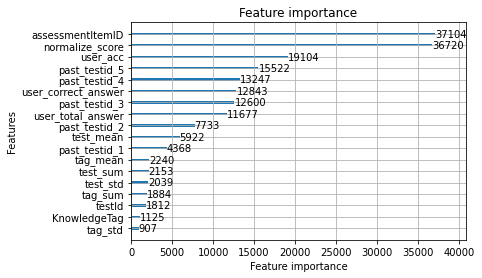

In [136]:
# INSTALL MATPLOTLIB IN ADVANCE
_ = lgb.plot_importance(model)

## 5. Inference

In [139]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = feature_engineering(test_df)
user_nomalize_df = test_df.groupby(['userID','testId'])['answerCode'].agg(['mean'])
user_nomalize_df.columns = ['user_testID_mean']
test_df = pd.merge(test_df, user_nomalize_df, on=['userID','testId'], how="left")
test_df['normalize_score'] = (test_df['user_testID_mean'] - test_df['test_mean']) / test_df['test_std']

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

In [140]:
test_df = past_testid_maker(test_df,5)


100%|██████████| 744/744 [00:00<00:00, 2157.26it/s]

100%|██████████| 744/744 [00:00<00:00, 2004.77it/s]

100%|██████████| 744/744 [00:00<00:00, 1984.48it/s]

100%|██████████| 744/744 [00:00<00:00, 1895.20it/s]

100%|██████████| 744/744 [00:00<00:00, 2001.76it/s]


In [144]:
test_df

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,...,tag_mean,tag_sum,tag_std,user_testID_mean,normalize_score,past_testid_1,past_testid_2,past_testid_3,past_testid_4,past_testid_5
1035,3,A050133008,A050000133,2020-10-26 13:13:57,5289,717.0,1035,0.692754,0.661765,90,...,0.542662,159,0.505845,0.625000,-0.074998,-1,-1,-1,-1,-1
1706,4,A070146008,A070000146,2020-12-27 02:47:54,9080,465.0,670,0.694030,0.740385,77,...,0.565693,155,0.552442,0.625000,-0.213833,-1,-1,-1,-1,-1
3023,13,A070111008,A070000111,2020-12-27 04:35:09,9660,915.0,1316,0.695289,0.417857,117,...,0.446753,172,0.518307,0.250000,-0.334850,-1,-1,-1,-1,-1
4283,17,A090064006,A090000064,2020-10-30 05:48:37,2611,1031.0,1259,0.818904,0.625000,30,...,0.514286,36,0.531415,0.666667,0.078475,-1,-1,-1,-1,-1
4670,26,A060135007,A060000135,2020-10-23 11:44:18,1422,293.0,386,0.759067,0.678571,133,...,0.602767,305,0.493836,0.428571,-0.521868,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260052,7395,A040122005,A040000122,2020-09-08 02:05:20,10615,7.0,23,0.304348,0.753846,147,...,0.654902,167,0.484530,0.000000,-1.699180,-1,-1,-1,-1,-1
260067,7404,A030111005,A030000111,2020-10-13 09:49:18,7636,7.0,14,0.500000,0.866667,156,...,0.834661,419,0.377186,0.200000,-1.867961,-1,-1,-1,-1,-1
260082,7416,A050193004,A050000193,2020-10-04 02:44:41,10402,7.0,14,0.500000,0.750000,75,...,0.792517,233,0.446234,0.250000,-1.043030,-1,-1,-1,-1,-1
260097,7417,A050193004,A050000193,2020-09-06 13:09:15,10402,2.0,14,0.142857,0.750000,75,...,0.792517,233,0.446234,0.250000,-1.043030,-1,-1,-1,-1,-1


In [141]:
cate= ['KnowledgeTag', 'testId','assessmentItemID','past_testid_1','past_testid_2','past_testid_3','past_testid_4','past_testid_5']
for c in cate:
    test_df[c] = test_df[c].astype('category')

In [142]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [143]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/submission.csv
